In [1]:
%matplotlib widget
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
import pickle
from amftrack.pipeline.functions.post_processing.extract_study_zone import load_study_zone
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, save_graphs, load_graphs, load_skel
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Edge
from amftrack.pipeline.functions.post_processing.area_hulls import *

from shapely.geometry import Polygon, shape,Point
from shapely.affinity import affine_transform, rotate
from scipy import spatial
import geopandas as gpd

/home/cbisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
directory = directory_project
# update_analysis_info(directory)
# directory = '/projects/0/einf914/agg/'

analysis_info = get_analysis_info(directory)
analysis_info['Plate']=analysis_info['Plate'].fillna(758)

In [6]:
select = analysis_info 
num = 13
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 799
1 790
2 792
3 800
4 22
4 22
5 80
6 10
7 76
8 102
9 94
10 88
11 26
12 808
13 152


In [8]:
load_study_zone(exp)
exp.labeled = True
load_graphs(exp,indexes = [0])

In [9]:
%load_ext autoreload
%autoreload 2
ts = range(exp.ts)
incr = 100
regular_hulls,indexes = get_regular_hulls_area_fixed(exp,ts,incr)

In [10]:
# path_save = f'/scratch-shared/amftrack/temp/time_plate_infos_agg.pick'
path_save = f'/scratch-shared/amftrack/temp/time_plate_infos.pick'

dir_drop = 'data_tables'

API = str(np.load(os.getenv('HOME')+'/pycode/API_drop.npy'))
# download(API,f'/{dir_drop}/time_plate_infos_agg.pick',path_save)
download(API,f'/{dir_drop}/time_plate_infos.pick',path_save)

time_plate_info = pd.read_pickle(path_save)
# time_plate_info['Plate'] = time_plate_info['Plate'].fillna(758)


In [18]:
plt.close("all")
from matplotlib import cm
import matplotlib as mpl
plate = row["Plate"]
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.fillna(-1)
my_cmap = cm.Greys
my_cmap.set_under('k', alpha=0)
table= table.set_index('t')
num_hulls = len(regular_hulls)-4
for t in ts:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    skels = []
    ims = []
    kernel = np.ones((5,5),np.uint8)
    itera = 2
    folders = list(exp.folders['folder'])
    folders.sort()
    for folder in folders[t:t+1]:
        directory_name=folder
        path_snap=directory+directory_name
        skel_info = read_mat(path_snap+'/Analysis/skeleton_realigned_compressed.mat')
        skel = skel_info['skeleton']
        skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))
    for index in range(num_hulls):
        polygon = regular_hulls[num_hulls-1-index]
        column = f"ring_density_incr-100_index-{num_hulls-1-index}"
        p = affine_transform(polygon,[0.2,0,0,-0.2,0,0])
        p = rotate(p,90,origin=(0,0))
        density = table[column][t]
        if density !=-1:
            p =gpd.GeoSeries(p)
            _ = p.plot(ax =ax,color = cm.cool(density/5000),alpha = 0.9)
        # _ = ax.plot(np.array(y)/5,np.array(x)/5)
    polygon = regular_hulls[0]
    column = f"ring_density_incr-100_index-{num_hulls-1-index}"
    p = affine_transform(polygon,[0.2,0,0,-0.2,0,0])
    p = rotate(p,90,origin=(0,0))
    p =gpd.GeoSeries(p)
    _ = p.plot(ax =ax,color = "black")
    norm = mpl.colors.Normalize(vmin=0, vmax=3000)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.cool), ax=ax,orientation='horizontal')
    ax.imshow(skels[0],vmin=0.00000001,cmap=my_cmap,zorder=30,interpolation =None)
    right = 0.90
    top = 0.90
    fontsize = 10
    text = ax.text(
    right,
    top,
    f"time = {int(table['time_since_begin'][t])}h",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="white",
    fontsize = fontsize,
)
    save = f'/scratch-shared/amftrack/temp/im{t}'
    plt.savefig(save)
    plt.close(fig)
    # break
# regular_hulls[1].scale(0.5,0.5).plot()

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys").copy()
  


findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.


In [19]:
img_array = []
for t in ts:
    save = f'/scratch-shared/amftrack/temp/im{t}.png'
    img = cv2.imread(save)
    img_array.append(img)
    
path_movie = f'/scratch-shared/amftrack/temp/{plate}.mp4'
imageio.mimsave(path_movie, img_array,fps=4)

In [20]:
from amftrack.transfer.functions.transfer import upload, zip_file
dir_drop = 'trash'

API = str(np.load(os.getenv('HOME')+'/pycode/API_drop.npy'))
upload(API,path_movie,f'/{dir_drop}/density_wave_{plate}.mp4',chunk_size=256 * 1024 * 1024)


In [9]:
t = 20
dist = 800
nodes = [node for node in exp.nodes if node.is_in(t)]
poss = [node.pos(t) for node in nodes]
lengths = [get_length_around(node,t,dist) for node in nodes]

In [13]:
pos_array = np.array(poss)


array([16908, 20535, 20211, 18569, 18984, 19124, 20010, 21526, 20227,
       26466, 25626, 19714, 21604, 24238, 22154, 21773, 19853, 24427,
       19955, 23759, 24329, 21662, 24287, 21767, 21887, 24041, 24585,
       21684, 19196, 19490, 24167, 20125, 23514, 24566, 23948, 19262,
       19403, 14458, 17477, 19321, 19235, 23786, 23872, 23096, 21216,
       23357, 16002, 17774, 18838, 19168, 17914, 22835, 23179, 23615,
       18090, 14370, 18198, 23230, 18349, 18413, 23472, 22568, 23226,
       18349, 21920, 17149, 20656, 18855, 22618, 22456, 18334, 22718,
       24428, 27348, 18334, 23291, 17174, 19066, 24375, 19049, 18536,
       16946, 17625, 17441, 18961, 19566, 11198, 18939, 18380, 19025,
       21626, 18245, 21610, 21784, 22080, 21415, 18393, 23045, 19148,
       18673, 18536, 18201, 18996, 21661, 18951, 22015, 18085, 18478,
       18431, 16244, 22054, 21876, 18957, 18166, 19042, 20941, 20875,
       18449, 19477, 18809, 15693, 18763, 18963, 21503, 15513, 15567,
       18666, 15701,

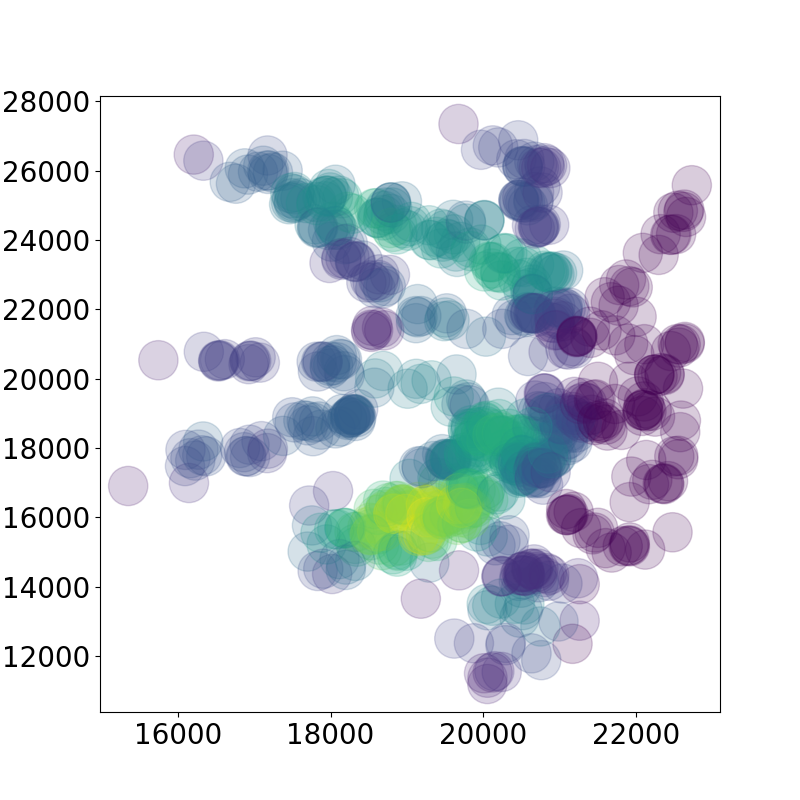

In [16]:
pos_array = np.array(poss)
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(pos_array[:,0],pos_array[:,1],s=dist,c=lengths,alpha = 0.2)

In [26]:
np.mean(np.array(lengths)/(np.pi*dist**2)*1000**2

array([  807.40292092,  1046.1419839 ,  3231.15691592,  3866.39643792,
        3866.39643792,  2940.06968103,  5367.85699359,  1100.54307364,
        5367.85699359,   996.58062818,  3780.79047309,  5533.76496586,
        4153.59202177,  8163.91768733,  4304.34582569,  4153.59202177,
        5792.18139817,  6155.18252049,  5868.7838901 ,  6695.72384507,
        6315.56579374,  5126.92586762,  6460.48894885,  5126.92586762,
        3917.51347713,  6460.48894885,  4925.59228509,  5126.92586762,
        6053.61179454,  6717.61304785,  6460.48894885,  4704.95724694,
        5303.01147837,  5490.83444368,  6465.74173488,  4517.46858841,
        5181.46984172,  2777.43104804,  3954.7378451 ,  4193.62317786,
        3487.22459669,  7046.22238194,  7120.94241327,  7777.18152024,
        4797.41984466,  7738.74727913, 10369.44533835,  7952.05683671,
        7426.26921957,  5150.67128538,  7549.88675102,  6926.26969588,
        7777.18152024,  6994.23334337,  8061.08048468,  1991.01877626,
      

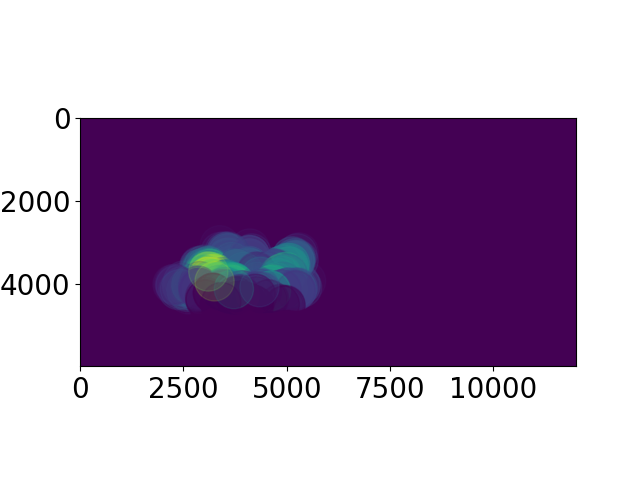

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(skels[0])
ax.scatter(pos_array[:,1]//5,pos_array[:,0]//5,s=dist,c=np.array(lengths)/(np.pi*dist**2)*1000**2,alpha = 0.2)

In [17]:
num = 10
ts = range(exp.ts)
regular_hulls1,indexes1 = get_regular_hulls(num,exp,ts)
regular_hulls2,indexes2 = get_regular_hulls_area_ratio(num,exp,ts)
regular_hulls3,indexes3 = get_regular_hulls_area_fixed(num,exp,ts,100)

indexes1,indexes2,indexes3

([0, 7, 9, 12, 15, 19, 22, 25, 28, 35],
 [0, 13, 17, 20, 23, 25, 27, 29, 35, 40],
 [0, 9, 12, 14, 16, 18, 19, 21, 22, 23])

In [107]:
num = 20
ts = range(exp.ts)
regular_hulls1,indexes1 = get_regular_hulls(num,exp,ts)
regular_hulls2,indexes2 = get_regular_hulls_area(num,exp,ts)
indexes1,indexes2

([0, 2, 7, 8, 9, 11, 12, 14, 15, 17, 19, 20, 22, 23, 25, 27, 28, 30, 35, 40],
 [0,
  10,
  13,
  15,
  17,
  19,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  31,
  35,
  39,
  40,
  42])

In [132]:
[ring_area(regular_hulls2[i],regular_hulls2[i+1]) for i in range(len(regular_hulls2)-1)]

[134.5492804809375,
 128.802204478125,
 98.36542606500001,
 120.13737194250001,
 130.60661008781256,
 75.90496073343752,
 158.60474181281256,
 85.8463780528125,
 71.36707160812489,
 130.55955206625003,
 90.03505824281251,
 164.03007836250003,
 87.40329498000006,
 91.98665760656263,
 92.29218436687484,
 136.70710255968766,
 92.85011256656253,
 106.26540395062489,
 92.61447431062516]

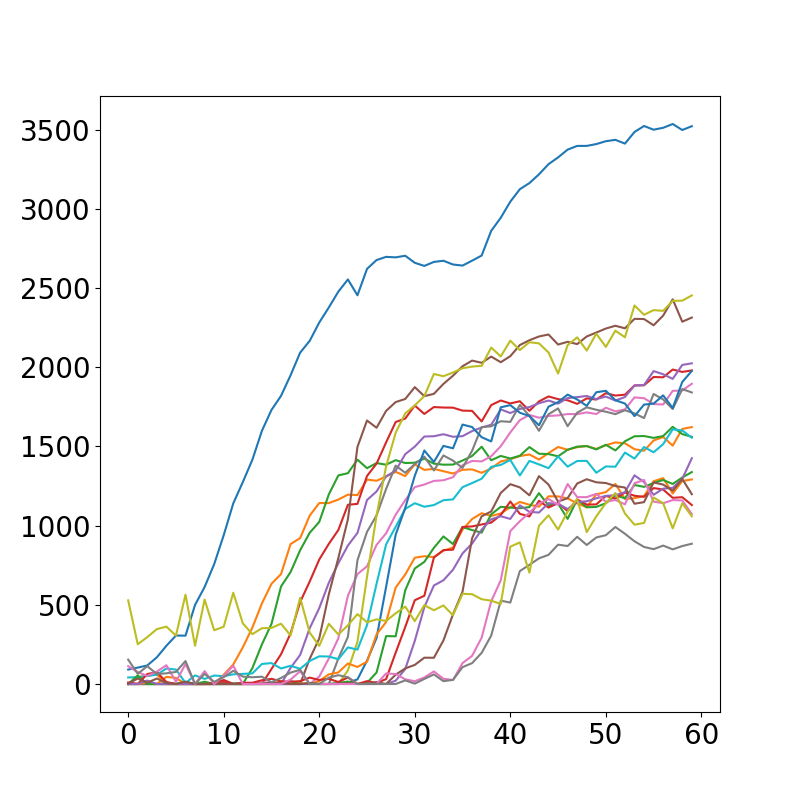

In [108]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(len(regular_hulls2)-1):
    hull1,hull2 = regular_hulls2[i],regular_hulls2[i+1]
    lengths = [get_length_in_ring(hull1,hull2,t) for t in range(exp.ts)]
    area= ring_area(hull1,hull2)
    ax.plot(range(exp.ts),np.array(lengths)/area)

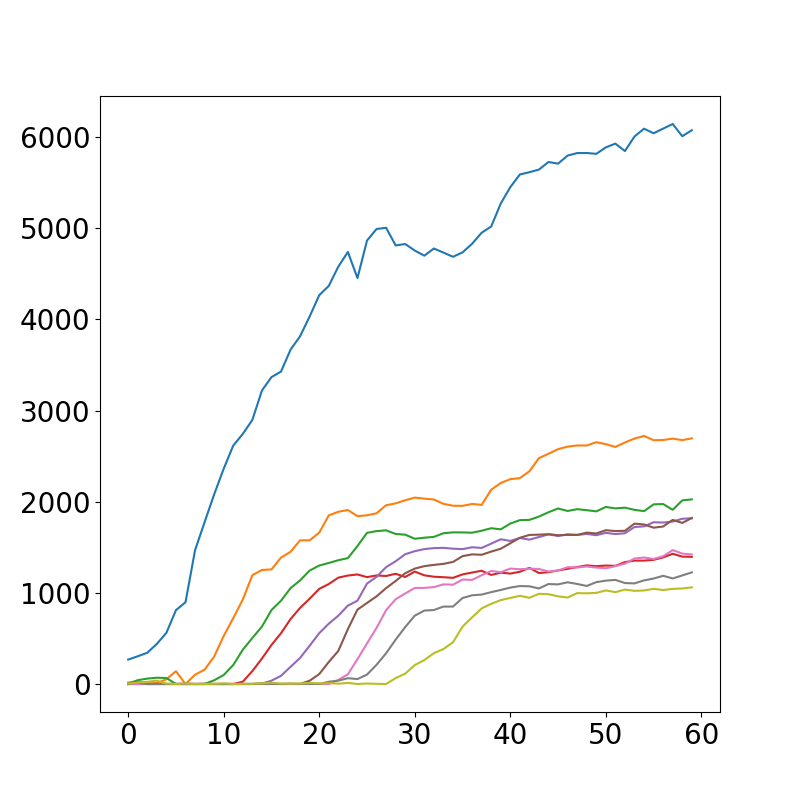

In [105]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(len(regular_hulls1)-1):
    hull1,hull2 = regular_hulls1[i],regular_hulls1[i+1]
    lengths = [get_length_in_ring(hull1,hull2,t) for t in range(exp.ts)]
    area= ring_area(hull1,hull2)
    ax.plot(range(exp.ts),np.array(lengths)/area)

In [ ]:
lengths = [get_length_in_ring(hull1,hull2,t) for t in range(exp.ts)]
area= ring_area(hull1,hull2)

In [130]:
t = 50
hull1,hull2 = regular_hulls2[-6],regular_hulls2[-5]
nodes = get_nodes_in_ring(hull1,hull2,t)
nodes_labels = [node.label for node in nodes]

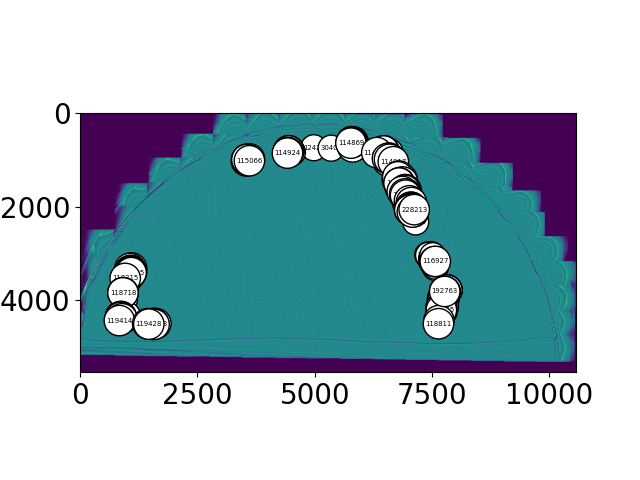

In [131]:
plt.close('all')

plot_raw_plus(exp,t,nodes_labels)

In [127]:
t = 50
hull1,hull2 = regular_hulls2[-9],regular_hulls2[-8]
nodes = get_nodes_in_ring(hull1,hull2,t)
nodes_labels = [node.label for node in nodes]

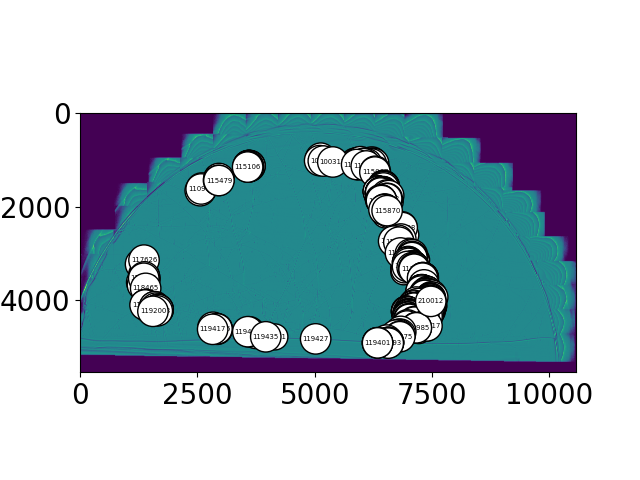

In [128]:
plt.close('all')

plot_raw_plus(exp,t,nodes_labels)

In [ ]:
def get_length_in_study_zone(exp,t,args):
    length=0
    excluded = []
    for edge in exp.nx_graph[t].edges:
        edge_obj= Edge(Node(edge[0],exp),Node(edge[1],exp),exp)
        is_in_end = np.all(is_in_study_zone(edge_obj.end,t,1000,150))
        is_in_begin = np.all(is_in_study_zone(edge_obj.begin,t,1000,150))
        if is_in_end and is_in_begin:
            length+= get_length_um_edge(edge_obj, t)
        else:
            excluded.append(edge_obj)
    print(len(excluded))
    return('tot_length',length)


def get_area(exp,t,args):
    nodes = np.array([node.pos(t) for node in exp.nodes if node.is_in(t)])
    if len(nodes)>0:
        hull=spatial.ConvexHull(nodes)
        poly = Polygon([nodes[vertice] for vertice in hull.vertices])
        area = poly.area* 1.725**2/(1000**2)
    else:
        area=0
    return('area',area)
